<a href="https://colab.research.google.com/github/yeabwang/malaria-diagnosis/blob/main/Malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This model os a binary classification model which classifies cells as infected or not infected.
# Dataset to be used https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
##### 27,558 cell images - from thin blood smear slides - contains both infected and uninfected cells.

In [93]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC, Precision, Recall

In [3]:
dataset,dataset_info = tfds.load('malaria',as_supervised=True,with_info=True, shuffle_files = True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.ZBZZLA_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [71]:
# Spliting our dataset into trianing, validation and testing

def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    train_dataset = dataset.take(int(train_ratio * dataset_size))  # Training set
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))  # Remaining
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))  # Validation set
    test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))  # Test set

    return train_dataset, val_dataset, test_dataset


In [72]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset,val_dataset,test_dataset = split_dataset(dataset[0],train_ratio,val_ratio,test_ratio)
# print(list(train_dataset.take(1).as_numpy_iterator())), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator())

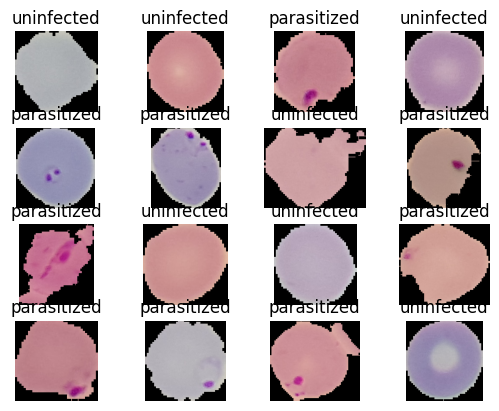

In [6]:
# Ploting some of the datas we have in our datset
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [73]:
# Resizing and Rescaling

image_size = 224

def resize_rescale(image, label):
    image = tf.image.resize(image, [image_size, image_size])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

train_dataset
val_dataset
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [74]:
#shuffling and taking a batch of our dataset

batch_size = 32

# For the training dataset
train_dataset = (
    train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# For the validation dataset
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For the test dataset
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [75]:
# Building our model

channel_size = 3

model = Sequential([
    InputLayer(shape=(image_size, image_size, channel_size)),

    # First Convolutional Block
    Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Third Convolutional Block (Optional)
    Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Dense Layer
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,185 (84.92 MB)

 Trainable params: 22,261,185 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
metrics = [
    BinaryAccuracy(name='accuracy'),
    TruePositives(name='tp'),
    TrueNegatives(name='tn'),
    FalsePositives(name='fp'),
    FalseNegatives(name='fn'),
    AUC(name='auc'),
    Precision(name='precision'),
    Recall(name='recall')
    ]

In [77]:
# Defining our optimizer, loss function, measurement metrics and compiling our model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= metrics,
)

In [ ]:
# # Calculating our loss
# # As one of the arguments in the Binary Cross Entrophy, if we are not sure that our output will be between 0 and one we have to use
# # from_logits = True to tell the model the prediction value might not be in the range of 0 and 1.

# y_true = np.array([0,])
# y_pred = np.array([0.8,])
# bce = BinaryCrossentropy(from_logits = False )

# loss = bce(y_true, y_pred)
# print("Binary Crossentropy Loss:", loss.numpy())


In [ ]:
# class LossCallback(Callback):
#     def on_epoch_end(self, epoch, logs):
#       print("\n For Epoch num {} the model has loss of {}".format(epoch+1, logs["loss"]))

#     def on_batch_end(self, batch, logs):
#       print("\n For Batch num {} the model has loss of {}".format(batch+1, logs))

In [67]:
# epoch and batch log
csv_callback = CSVLogger('log.csv', separator=',', append=False)

In [78]:
# Setting regularizations
# Having a smooth linear warmup rate at the starts improve our models stability and leads to a better outcome.
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    min_delta = 0,
    restore_best_weights=True,
    mode = 'auto',
    verbose=1
)

# Speed and stability
# learning_rate_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

# datasetsize/batch_size = no of epochs

In [79]:
# Training our model

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[callbacks, csv_callback ],
    verbose=1
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5552 - auc: 0.5891 - fn: 1915.6720 - fp: 2772.3484 - loss: 0.6943 - precision: 0.5515 - recall: 0.6578 - tn: 2738.5850 - tp: 3613.3918
Epoch 1: val_loss improved from inf to 0.38476, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.5553 - auc: 0.5892 - fn: 1918.1318 - fp: 2775.3999 - loss: 0.6943 - precision: 0.5516 - recall: 0.6578 - tn: 2743.5203 - tp: 3618.8958 - val_accuracy: 0.8991 - val_auc: 0.9331 - val_fn: 31.0000 - val_fp: 247.0000 - val_loss: 0.3848 - val_precision: 0.8460 - val_recall: 0.9777 - val_tn: 1120.0000 - val_tp: 1357.0000 - learning_rate: 0.0010
Epoch 2/5
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8876 - auc: 0.9236 - fn: 149.7079 - fp: 1087.3575 - loss: 0.3552 - precision: 0.8316 - recall: 0.9749 - tn: 4415.3037 - tp: 5371.6309
Epoch 2: val_loss improved from 0.38476 to 0.18296, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 61

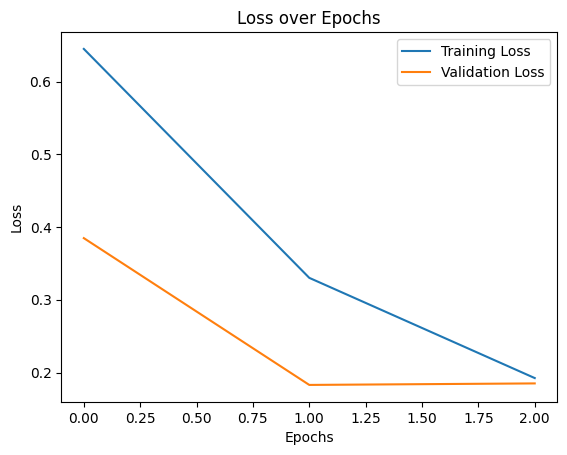

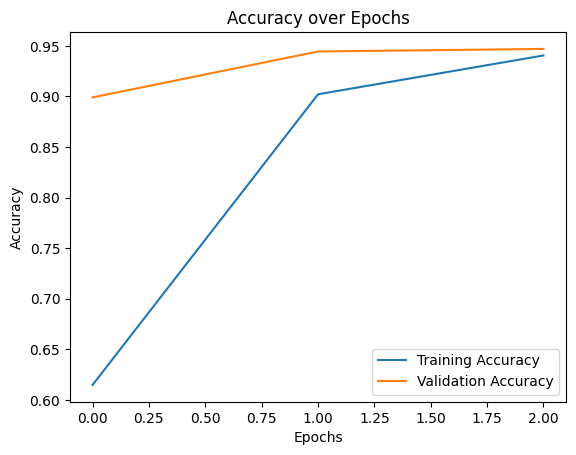

In [80]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
# # Evaluate on the validation dataset
# val_loss, val_accuracy, val_auc = model.evaluate(val_dataset, verbose=1)
# print(f"Validation Loss: {val_loss:.4f}")
# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print(f"Validation AUC: {val_auc:.4f}")

# # Evaluate on the test dataset
# test_loss, test_accuracy, test_auc = model.evaluate(test_dataset, verbose=1)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"Test AUC: {test_auc:.4f}")

In [29]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9547 - auc: 0.9832 - fn: 26.5455 - fp: 38.1364 - loss: 0.1705 - precision: 0.9476 - recall: 0.9631 - tn: 674.0000 - tp: 684.3409


[0.1618335098028183,
 0.9532099962234497,
 1309.0,
 1319.0,
 76.0,
 53.0,
 0.9840665459632874,
 0.9451263546943665,
 0.961086630821228]

In [81]:
labels = []
inp = []

# Collect data from the dataset
for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

inp_array = np.concatenate(inp, axis=0)
labels_array = np.concatenate(labels, axis=0)

print(f"Input shape: {inp_array.shape}")
print(f"Labels shape: {labels_array.shape}")

Input shape: (2757, 224, 224, 3)
Labels shape: (2757,)


In [82]:
predicted = model.predict(inp_array)[:,0,...]
# print(predicted.shape)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


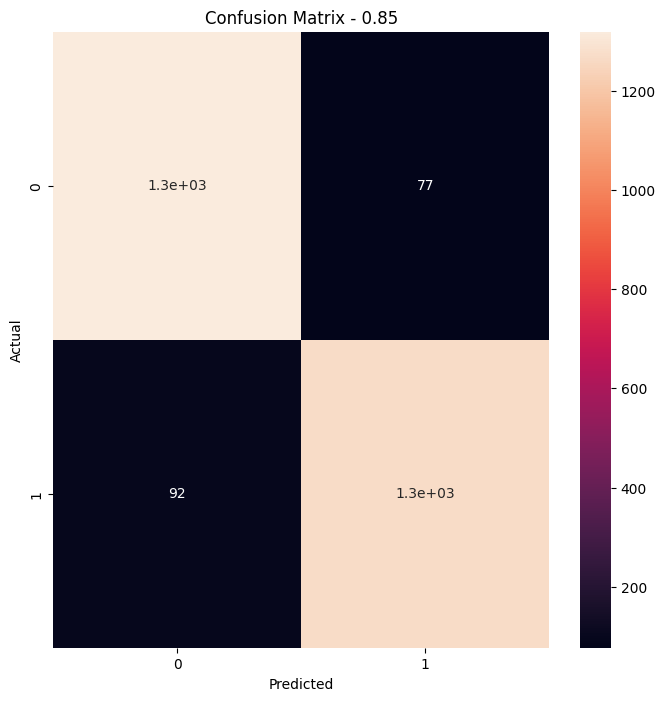

In [91]:
threshold = 0.85

con_metrics = confusion_matrix(labels_array, predicted > threshold)
plt.figure(figsize=(8,8))

sns.heatmap(con_metrics, annot=True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [84]:
predicted = model.predict(inp_array).flatten()

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


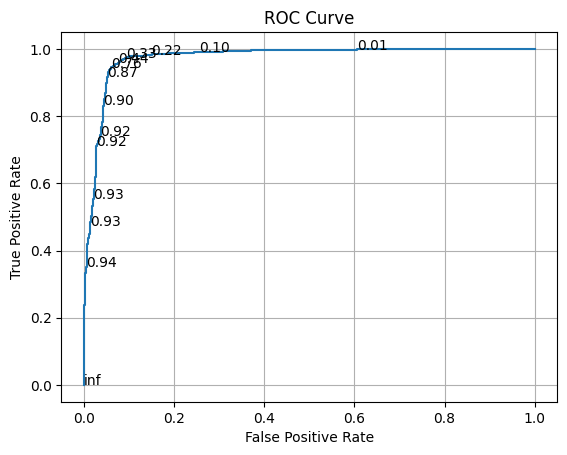

In [85]:
fp, tp, thresholds = roc_curve(labels_array, predicted)

# Plot ROC curve
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()

# Annotate thresholds
skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], f"{thresholds[i]:.2f}")

plt.show()

In [92]:
model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


0.93283486

In [51]:
def labeler(x):
  if(x<0.5):
    return str('Postivie')
  else:
    return str('Negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


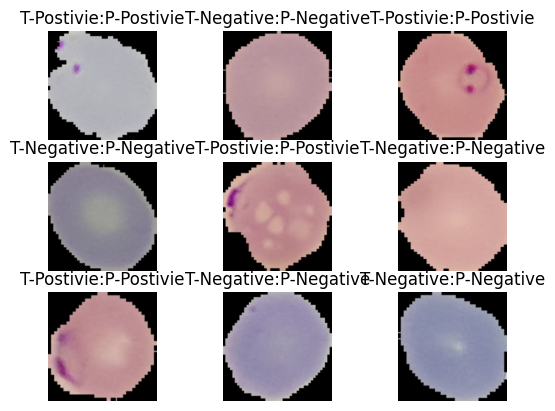

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str("T-"+labeler(label.numpy()[0])) + ":" + str("P-"+labeler(model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
# Confusion Matrix
# When you choose your model from a confusion matrix you should access the risk assessment on the outcome and choose.

